## 2. Load Data and Train a model then save the model's weight

**Used Hyperparameter**<br>
Without Data Augmentation<br>


-----------------------<br>
Level: 3,4,5 images <br>
Number of train,val,test: 12, 3, 3 <br>
train's stride : 200 <br>
test's stride: 299 <br>
tissue percent min: 50 <br>


In [ ]:
import numpy as np
import os
from PIL import Image
import pathlib
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from matplotlib.patches import Rectangle
import re
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
import os

# Initialization
lowest_level = 2
highest_level = 3
train_val_stride = 200
test_stride = 299
tissue_p_min = 50

dir = '/content/drive/MyDrive/Applied_Deep_Learning_Project/'
current_dir = 'Lev_345_split_933_stride_150_pmin_50'
saving_dir = os.path.join(dir,current_dir)
saving_dir

'/content/drive/MyDrive/Applied_Deep_Learning_Project/save_data_345_150_200'

In [ ]:
# Mount drive
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)
print()

# Check TensorFlow version
import tensorflow as tf 
print("TF version: ", tf.__version__)
print()

# Check which GPU with available RAM
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

Mounted at /content/drive

TF version:  2.4.0

Found GPU at: /device:GPU:0
name, driver_version, memory.total [MiB]
Tesla V100-SXM2-16GB, 418.67, 16130 MiB


In [ ]:
zoom1_train = np.load(os.path.join(saving_dir,'zoom1_train.npy'))
zoom2_train = np.load(os.path.join(saving_dir,'zoom2_train.npy'))
zoom3_train = np.load(os.path.join(saving_dir,'zoom3_train.npy'))
label_train = np.load(os.path.join(saving_dir,'label_train.npy'))

zoom1_valid = np.load(os.path.join(saving_dir,'zoom1_valid.npy'))
zoom2_valid = np.load(os.path.join(saving_dir,'zoom2_valid.npy'))
zoom3_valid = np.load(os.path.join(saving_dir,'zoom3_valid.npy'))
label_valid = np.load(os.path.join(saving_dir,'label_valid.npy'))

In [ ]:
def create_inceptionv3(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  base_model.trainable = False
  return base_model


def create_inceptionv3_fine_tune(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  
  base_model.trainable = True
  # Let's take a look to see how many layers are in the base model
  print("Number of layers in the base InceptionV3 model: ", len(base_model.layers))
  # Fine-tune from this layer onwards
  fine_tune_at = 100
  print("Start fine tuning at layer: ", fine_tune_at)

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  return base_model


def create_global_avg_layer():
  return tf.keras.layers.GlobalAveragePooling2D()


def create_dense_layer():
  return tf.keras.layers.Dense(1024, activation='relu')

In [ ]:
# Reference used to put multiple inputs
# # https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_three(fine_tune):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
    base_model_3 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()
    base_model_3 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_3 = tf.keras.Sequential([
    base_model_3,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
  input3 = Input(shape=(299,299,3))
    
  model_concat = concatenate([model_1(input1) ,model_2(input2),model_3(input3)])
  model = Dense(1024, activation='relu')(model_concat)
  model = Dense(1, activation='sigmoid')(model)
  model_final = Model(inputs=[input1,input2,input3],outputs=model)

  return model_final

In [ ]:
# A plotting function you can reuse
def plot(history):
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  # added new version for better layout in visualization (for fun)
  fig, ax = plt.subplots(1,2, figsize = (14,5))
  ax[0].set_title('Training and validation accuracy')
  ax[0].plot(epochs, acc, color='blue', label='Train')
  ax[0].plot(epochs, val_acc, color='orange', label='Val')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()

  ax[1].set_title('Training and validation loss')
  ax[1].plot(epochs, loss, color='blue', label='Train')
  ax[1].plot(epochs, val_loss, color='orange', label='Val')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()

### Version a: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         23900960    input_4[0][0]                    
______________________________________________________________________________________________

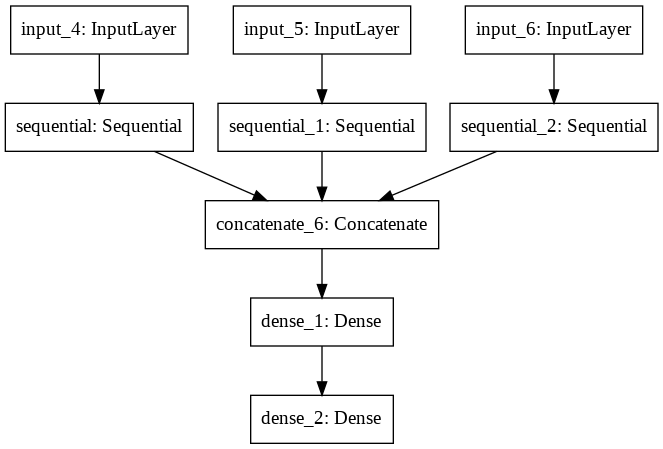

In [ ]:
mdl_9_3_wo_ft_wo_da = create_model_keras_inputs_three(fine_tune = False)
mdl_9_3_wo_ft_wo_da.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da))

Epoch 1/10
235/235 [==============================] - 97s 342ms/step - loss: 10.0914 - accuracy: 0.8020 - val_loss: 0.2730 - val_accuracy: 0.9085
Epoch 2/10
235/235 [==============================] - 76s 324ms/step - loss: 0.2277 - accuracy: 0.9175 - val_loss: 0.2468 - val_accuracy: 0.9203
Epoch 3/10
235/235 [==============================] - 76s 324ms/step - loss: 0.2144 - accuracy: 0.9211 - val_loss: 0.2362 - val_accuracy: 0.9144
Epoch 4/10
235/235 [==============================] - 76s 324ms/step - loss: 0.2258 - accuracy: 0.9141 - val_loss: 0.3541 - val_accuracy: 0.8712
Epoch 5/10
235/235 [==============================] - 76s 324ms/step - loss: 0.1904 - accuracy: 0.9283 - val_loss: 0.3927 - val_accuracy: 0.8592
Epoch 6/10
235/235 [==============================] - 76s 324ms/step - loss: 0.1660 - accuracy: 0.9366 - val_loss: 0.2674 - val_accuracy: 0.9085
Epoch 7/10
235/235 [==============================] - 76s 324ms/step - loss: 0.1345 - accuracy: 0.9568 - val_loss: 0.2987 - val_a

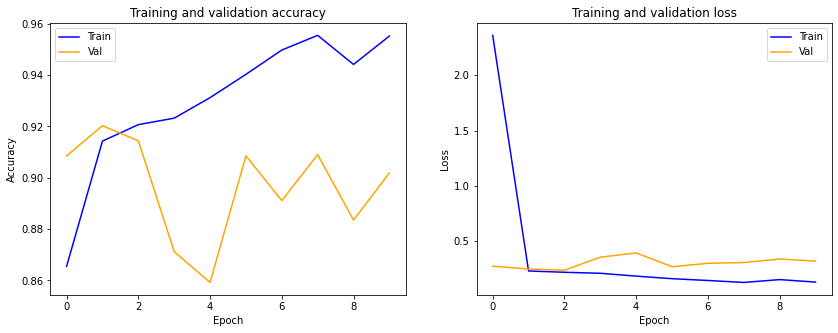

In [ ]:
mdl_9_3_wo_ft_wo_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

X_train = [zoom1_train, zoom2_train, zoom3_train]
X_valid = [zoom1_valid, zoom2_valid, zoom3_valid]

BATCH_SIZE = 32
plot(mdl_9_3_wo_ft_wo_da.fit(X_train,label_train, batch_size=BATCH_SIZE,
                             validation_data =(X_valid, label_valid),  epochs=10))

In [ ]:
#save_weights
mdl_9_3_wo_ft_wo_da.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da.h5/"))

del mdl_9_3_wo_ft_wo_da

### Version b: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **without** data augmentation

In [ ]:
mdl_9_3_w_ft_wo_da = create_model_keras_inputs_three(fine_tune = True)
mdl_9_3_w_ft_wo_da.summary()
# display(plot_model(mdl_9_3_w_ft_wo_da))

87916544/87910968 [==============================] - 1s 0us/step
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 299, 299, 3) 0              

Epoch 1/10
235/235 [==============================] - 166s 586ms/step - loss: 0.4902 - accuracy: 0.8644 - val_loss: 1.2722 - val_accuracy: 0.8948
Epoch 2/10
235/235 [==============================] - 132s 562ms/step - loss: 0.1544 - accuracy: 0.9483 - val_loss: 0.4686 - val_accuracy: 0.8921
Epoch 3/10
235/235 [==============================] - 132s 562ms/step - loss: 0.1112 - accuracy: 0.9647 - val_loss: 0.4022 - val_accuracy: 0.9068
Epoch 4/10
235/235 [==============================] - 132s 561ms/step - loss: 0.1028 - accuracy: 0.9652 - val_loss: 3.9320 - val_accuracy: 0.8921
Epoch 5/10
235/235 [==============================] - 132s 562ms/step - loss: 0.0727 - accuracy: 0.9760 - val_loss: 0.3198 - val_accuracy: 0.9073
Epoch 6/10
235/235 [==============================] - 132s 562ms/step - loss: 0.0820 - accuracy: 0.9747 - val_loss: 0.3516 - val_accuracy: 0.9198
Epoch 7/10
235/235 [==============================] - 132s 562ms/step - loss: 0.0625 - accuracy: 0.9800 - val_loss: 0.5463 -

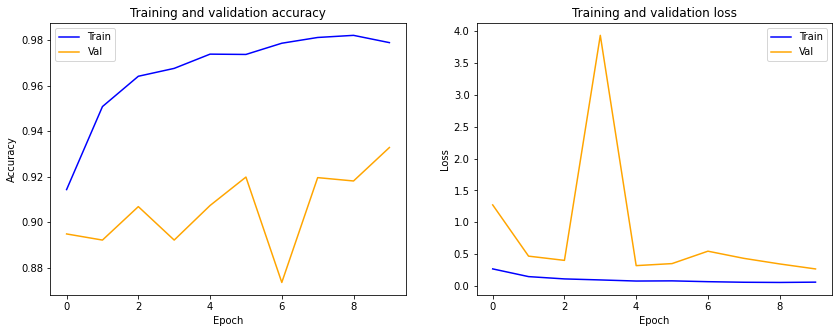

In [ ]:
mdl_9_3_w_ft_wo_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

X_train = [zoom1_train, zoom2_train, zoom3_train]
X_valid = [zoom1_valid, zoom2_valid, zoom3_valid]

BATCH_SIZE = 32
plot(mdl_9_3_w_ft_wo_da.fit(X_train,label_train, batch_size=BATCH_SIZE, 
                             validation_data =(X_valid, label_valid),  epochs=10))

In [ ]:
#save_weights
mdl_9_3_w_ft_wo_da.save_weights(os.path.join(saving_dir,"mdl_9_3_w_ft_wo_da.h5/"))

del mdl_9_3_w_ft_wo_da

### Version c: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **with** data augmentation

In [ ]:
# Reference used to take multiple inputs for ImageData Geneartor
# https://stackoverflow.com/questions/49404993/keras-how-to-use-fit-generator-with-multiple-inputs

gen = ImageDataGenerator(
    rotation_range=90,
    shear_range=0.2)
    # horizontal_flip = True,
    # vertical_flip = True)

gen_valid = ImageDataGenerator()

def generator_two_img(X1, X2, y, batch_size):
    genX1 = gen.flow(X1, y,  batch_size=batch_size, seed=1)
    genX2 = gen.flow(X2, y, batch_size=batch_size, seed=1)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

def generator_two_img_valid(X1, X2, y, batch_size):
    genX1 = gen_valid.flow(X1, y,  batch_size=batch_size, seed=1)
    genX2 = gen_valid.flow(X2, y, batch_size=batch_size, seed=1)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

X_train_ = generator_two_img(zoom1_train, zoom2_train, label_train, 32)
#X_valid_ = generator_two_img_valid(zoom1_valid, zoom2_valid, label_valid, 32)
BATCH_SIZE = 32

In [ ]:
mdl_9_3_wo_ft_w_da = create_model_keras_inputs_three(fine_tune = False)
mdl_9_3_wo_ft_w_da.summary()
# display(plot_model(mdl_9_3_wo_ft_w_da))

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         23900960    input_4[0][0]                    
_____________________________

In [ ]:
mdl_9_3_wo_ft_w_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

history_mdl_9_3_wo_ft_w_da = mdl_9_3_wo_ft_w_da.fit(X_train_, batch_size=BATCH_SIZE, steps_per_epoch = len(zoom1_train)/BATCH_SIZE,
                            validation_data = ([zoom1_valid,zoom2_valid,zoom3_valid],label_valid), shuffle=False, epochs=15)
plot(history_mdl_9_3_wo_ft_w_da)

In [ ]:
#save_weights
mdl_9_3_wo_ft_w_da.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_w_da.h5/"))

del mdl_9_3_wo_ft_w_da

### Version d: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **with** data augmentation

In [ ]:
mdl_9_3_w_ft_w_da = create_model_keras_inputs_two(fine_tune = True)
mdl_9_3_w_ft_w_da.summary()
# display(plot_model(mdl_9_3_w_ft_w_da))

Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 1024)         23900960    input_15[0][0]                   
__________________________________________________________________________________________________
sequential_7 (Seque

Epoch 1/15
172/172 [==============================] - 189s 1s/step - loss: 0.5253 - accuracy: 0.7833 - val_loss: 2.4569 - val_accuracy: 0.4259
Epoch 2/15
172/172 [==============================] - 178s 1s/step - loss: 0.2366 - accuracy: 0.9195 - val_loss: 10.1804 - val_accuracy: 0.4966
Epoch 3/15
172/172 [==============================] - 178s 1s/step - loss: 0.1724 - accuracy: 0.9322 - val_loss: 3.3666 - val_accuracy: 0.4983
Epoch 4/15
172/172 [==============================] - 178s 1s/step - loss: 0.1551 - accuracy: 0.9448 - val_loss: 1.4231 - val_accuracy: 0.5500
Epoch 5/15
172/172 [==============================] - 177s 1s/step - loss: 0.1342 - accuracy: 0.9479 - val_loss: 3.9771 - val_accuracy: 0.4862
Epoch 6/15
172/172 [==============================] - 177s 1s/step - loss: 0.1675 - accuracy: 0.9496 - val_loss: 1.3661 - val_accuracy: 0.5603
Epoch 7/15
172/172 [==============================] - 178s 1s/step - loss: 0.1046 - accuracy: 0.9641 - val_loss: 1.9574 - val_accuracy: 0.546

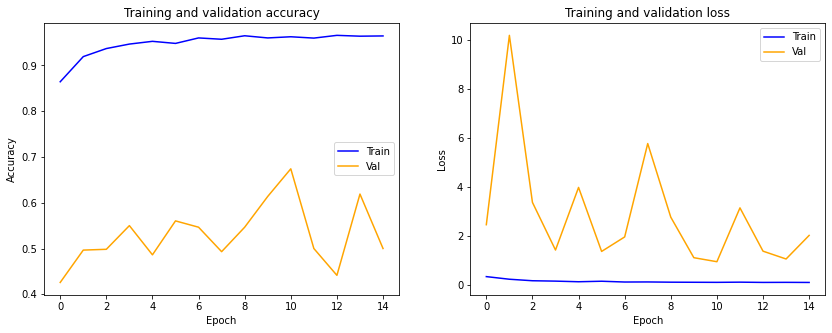

In [ ]:
mdl_9_3_w_ft_w_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_w_ft_w_da.fit(X_train_, batch_size=BATCH_SIZE, 
                steps_per_epoch = len(zoom1_train)/BATCH_SIZE,
                validation_data =X_valid_, validation_steps = len(zoom1_valid)/BATCH_SIZE, shuffle=False, epochs=15))

In [ ]:
#save_weights
mdl_9_3_w_ft_w_da.save_weights(os.path.join(saving_dir,"mdl_9_3_w_ft_w_da.h5/"))

del mdl_9_3_w_ft_w_da

Since verions **C** (**with** fine tuning and **without** data augmentation) works best, would continue using the model. Also, make fancier model to the base model above by including **batch normailzation** and **dropout**

### Version 2.1: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **without** data augmentation
#### Dropout applied after concatenating Inception V3 model

## 나중에 BatchNormalization도 넣어야함

In [ ]:
def create_batch_normalization():
  return tf.keras.layers.BatchNormalization()

In [ ]:
# Reference used to put multiple inputs
# https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_two_updated(fine_tune):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
    base_model_3 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()
    base_model_3 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()
  batch_norm_layer = create_batch_normalization()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    # batch_norm_layer
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    # batch_norm_layer
    #prediction_layer
  ])

  model_3 = tf.keras.Sequential([
    base_model_3,
    global_avg_layer,
    dense_layer,
    # batch_norm_layer
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
  input3 = Input(shape=(299,299,3))
    
  model_concat = concatenate([model_1(input1) ,model_2(input2),model_3(input3)], axis =1)
  model = tf.keras.layers.BatchNormalization()(model_concat)
  model = tf.keras.layers.Dropout(0.3)(model)
  model = Dense(1024, activation='relu')(model)
  model = tf.keras.layers.Dropout(0.3)(model)
  model = Dense(128, activation='relu')(model)
  model = tf.keras.layers.Dropout(0.3)(model)
  model = Dense(1, activation='sigmoid')(model)
  model_final = Model(inputs=[input1,input2,input3],outputs=model)

  return model_final

Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________

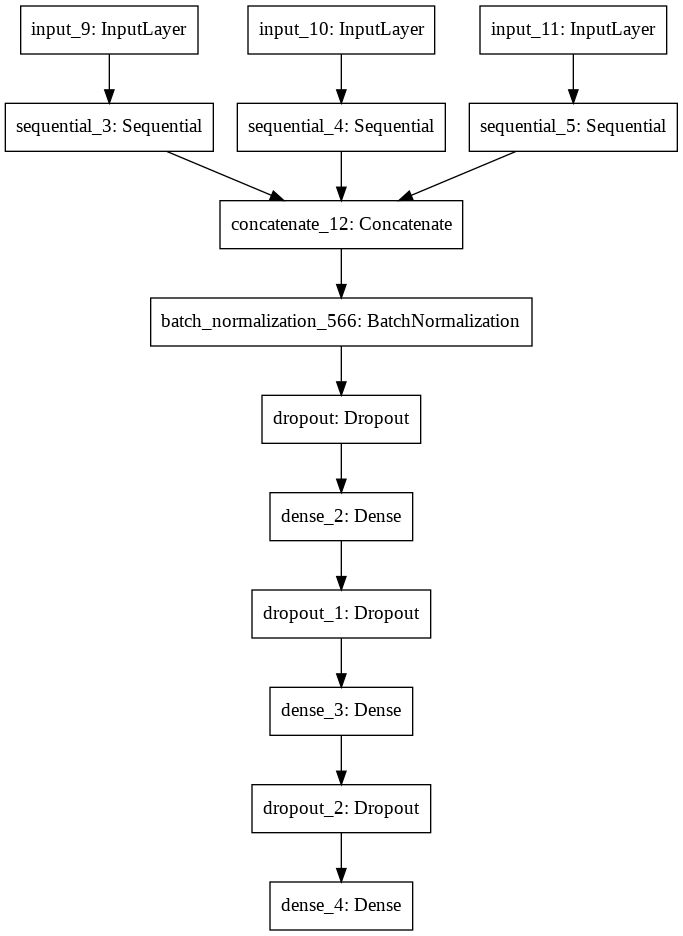

In [ ]:
mdl_9_3_w_ft_wo_da_Dropout = create_model_keras_inputs_two_updated(fine_tune = True)
mdl_9_3_w_ft_wo_da_Dropout.summary()
display(plot_model(mdl_9_3_w_ft_wo_da_Dropout))

Epoch 1/15
235/235 [==============================] - 170s 598ms/step - loss: 0.3713 - accuracy: 0.8715 - val_loss: 0.6722 - val_accuracy: 0.9245
Epoch 2/15
235/235 [==============================] - 135s 575ms/step - loss: 0.1798 - accuracy: 0.9418 - val_loss: 1.3107 - val_accuracy: 0.9193
Epoch 3/15
235/235 [==============================] - 135s 575ms/step - loss: 0.1430 - accuracy: 0.9577 - val_loss: 0.6363 - val_accuracy: 0.9105
Epoch 4/15
235/235 [==============================] - 135s 574ms/step - loss: 0.0944 - accuracy: 0.9673 - val_loss: 0.5973 - val_accuracy: 0.9110
Epoch 5/15
235/235 [==============================] - 135s 574ms/step - loss: 0.0781 - accuracy: 0.9786 - val_loss: 2.0441 - val_accuracy: 0.9274
Epoch 6/15
235/235 [==============================] - 135s 574ms/step - loss: 0.0766 - accuracy: 0.9756 - val_loss: 0.4976 - val_accuracy: 0.9338
Epoch 7/15
235/235 [==============================] - 135s 574ms/step - loss: 0.0890 - accuracy: 0.9755 - val_loss: 0.2774 -

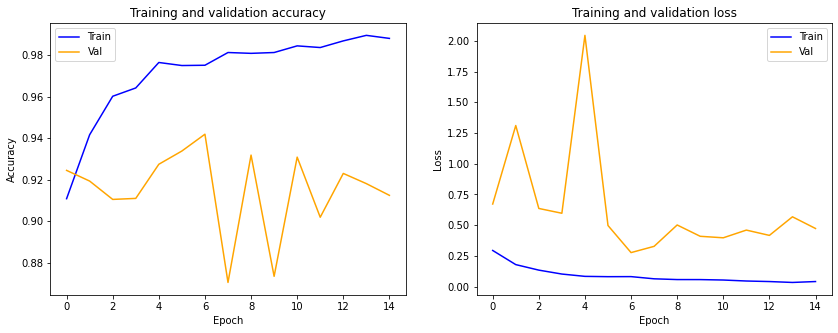

In [ ]:
mdl_9_3_w_ft_wo_da_Dropout.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy'])

X_train = [zoom1_train, zoom2_train,zoom3_train]
X_valid = [zoom1_valid, zoom2_valid,zoom3_valid]

BATCH_SIZE = 32

plot(mdl_9_3_w_ft_wo_da_Dropout.fit(X_train,label_train, 
                batch_size=BATCH_SIZE, 
                validation_data =(X_valid, label_valid),  epochs=15))

In [ ]:
#save_weights
mdl_9_3_w_ft_wo_da_Dropout.save_weights(os.path.join(saving_dir,"mdl_9_3_w_ft_wo_da_Dropout.h5/"))

del mdl_9_3_w_ft_wo_da_Dropout

In [ ]:

# mdl_9_3_w_ft_wo_da_Dropout.load_weights(os.path.join(saving_dir,"mdl_9_3_w_ft_wo_da_Dropout.h5/"))